# Breaking Down xMins

If you know the expected minutes a player will play, can you estimate the probabilties they will play, start, and the expected minutes for given scenarios?

### Load the libraries and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Load CSV
pmd = pd.read_csv('../views/player_match_data_21-23 (1).csv')

# Keep players with two full season's worth of data
pmd = pmd.groupby('e_code').filter(lambda x: len(x) == 76)

# Missing data from the following columns are zeros
zero_cols = ['Mins', 'On', 'Starts', 'Off']
pmd[zero_cols] = pmd[zero_cols].fillna(0)

# Get required cols and add useful column
pmd['Plyd'] = (pmd['Starts'] == 1) | (pmd['On'] == 1)
req_cols = ['e_code', 'Mins', 'Starts', 'Plyd', 'On', 'Off', 'Available']
pmd = pmd[req_cols].astype('int64')

pmd.sample(10)

/tmp/ipykernel_3344/1837808242.py:8: DtypeWarning: Columns (0,8,9,13,21,27) have mixed types. Specify dtype option on import or set low_memory=False.
  pmd = pd.read_csv('../views/player_match_data_21-23 (1).csv')


,e_code,Mins,Starts,Plyd,On,Off,Available
30784,228044,0,0,0,0,0,1
26606,433979,0,0,0,0,0,0
58782,40145,0,0,0,0,0,1
35534,120202,0,0,0,0,0,0
61398,512462,0,0,0,0,0,1
33971,220598,0,0,0,0,0,0
16244,195546,90,1,1,0,0,1
24383,440854,0,0,0,0,0,1
63345,174310,0,0,0,0,0,1
46926,476938,0,0,0,0,0,1


### Analysis
How does expected minutes affect the frequency of playing any given game?

In [2]:
agg = pmd.loc[pmd.Available == 1].groupby('e_code').mean()

agg.sort_values('Mins', ascending=False).head(5)

,Mins,Starts,Plyd,On,Off,Available
e_code,,,,,,
98980,86.538462,0.961538,0.961538,0.000000,0.000000,1.0
116535,85.846154,0.953846,0.953846,0.000000,0.000000,1.0
226597,85.184211,0.960526,0.960526,0.000000,0.065789,1.0
223340,81.297297,0.959459,1.000000,0.040541,0.445946,1.0
184029,77.942308,0.903846,0.980769,0.076923,0.442308,1.0


Let's see how a linear regression fits average minutes played and proportion of games played.

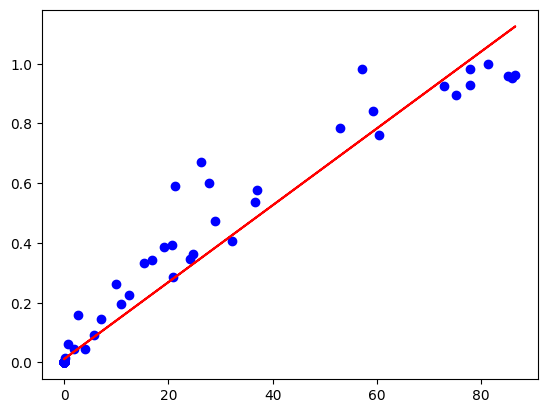

In [3]:
# Assign X and y
X = agg[['Mins']].values
y = agg['Plyd'].values

def show_linear_fit(X, y, bias=True, weights=None, ax=None):
    show = False

    # Fit the model
    model = LinearRegression(fit_intercept=bias)
    if weights is not None:
        model.fit(X, y, sample_weight=weights)
    else:
        model.fit(X, y)

    # Predict y-values
    y_pred = model.predict(X)

    # plot dataset
    if ax is None:
        ax = plt
        show = False
    ax.scatter(X, y, color='blue')
    ax.plot(X, y_pred, color='red')
    if show:
        plt.show()

    return model

_ = show_linear_fit(X, y)

The model is visibly underfitting the data. The trend of the data seems to curve. Let's try fitting a quadratic line instead.

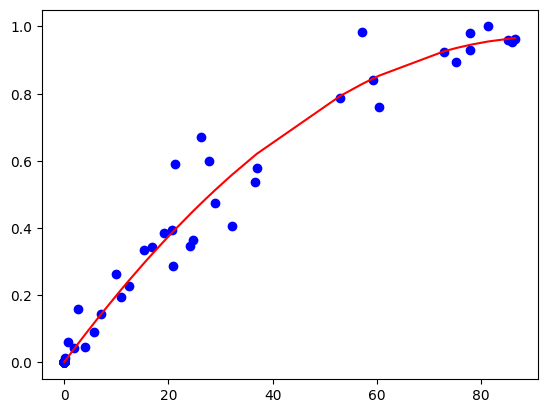

In [4]:
def show_poly_fit(X, y, bias=True, weights=None, degrees=2, ax=None):
    show = False

    # Setup the polynomial features
    degree = degrees
    poly_features = PolynomialFeatures(degree, include_bias=bias)

    # Transforms the existing features to higher degree features.
    X_poly = poly_features.fit_transform(X)

    # Fit the transformed features to Linear Regression
    model = LinearRegression(fit_intercept=bias)
    if weights is not None:
        model.fit(X_poly, y, sample_weight=weights)
    else:
        model.fit(X_poly, y)

    # Predicting on all values
    y_poly_pred = model.predict(X_poly)

    # Sorting predicted values with respect to predictor
    X_sorted = sorted(X.flatten().tolist())
    y_sorted = sorted(zip(X.flatten().tolist(), y_poly_pred.tolist()))
    y_sorted = [y for x, y in y_sorted]

    # plot dataset
    if ax is None:
        ax = plt
        show = True
    ax.scatter(X, y, color='blue')
    ax.plot(X_sorted, y_sorted, color='red')
    if show:
        plt.show()

    return poly_features, model

plyd_poly_features, plyd_model = show_poly_fit(X, y)

Perfect! We can use this straight away. The data is well distributed and the line fits well.

We also need to know the probabilities of starting in the event a player plays and their expected minutes.

In [5]:
agg = pmd.loc[pmd.Plyd == 1].groupby('e_code').mean()

agg.sort_values('Mins', ascending=False).head(5)

,Mins,Starts,Plyd,On,Off,Available
e_code,,,,,,
116535,90.000000,1.000000,1.0,0.000000,0.000000,0.849315
226597,88.684932,1.000000,1.0,0.000000,0.068493,1.000000
98980,88.486111,1.000000,1.0,0.000000,0.027778,0.347222
169187,83.811594,0.956522,1.0,0.043478,0.188406,0.855072
199796,81.390625,0.906250,1.0,0.093750,0.125000,0.828125


Again, let's start with a linear regression.

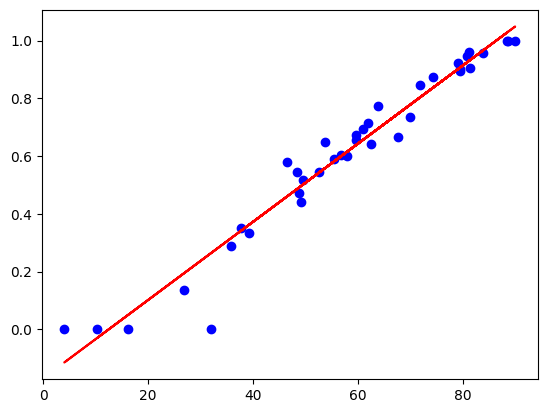

In [6]:
# Assign X and y
X = agg[['Mins']].values
y = agg['Starts'].values

_ = show_linear_fit(X, y)

At first glance, the trend of the data seems to be linear and the line seems to fit well. However, the line does not satisfy boundary conditions well. We want it to pass through (0 Mins, 0%) and (90 Mins, 100%). The line should also never be outside 100% and 0% between 0 and 90 minutes.

Let's try a cubic fit (but without a bias to ensure it passes through (0, 0)).

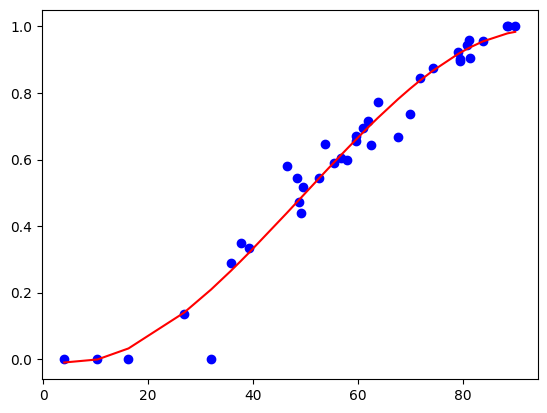

In [7]:
_, _ = show_poly_fit(X, y, bias=False, degrees=3)

It fits well. That said, the data is very top heavy here. The larger number of samples at the higher end effectively weights other samples lower. We should compensate for this by weighting the data to create roughly a even weighted sample distribution.

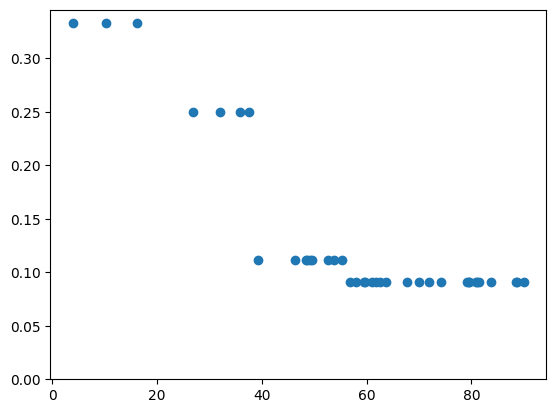

In [9]:
def weight_X(X, bins):
    # Bin the X array
    counts, bin_edges = np.histogram(X, bins=bins)

    # Bin the array like above
    indices = np.digitize(X.flatten(), bin_edges[:-1])

    # Replace each element with its bin count
    counts_in_bins = np.array([counts[i - 1] for i in indices])

    # Divide each element in the array by the count of elements in its bin
    return 1.0 / counts_in_bins

# Weight the data by inversing the frequency distribution
weights = weight_X(X, 5)

# Plot weights for each Mins point
plt.scatter(X.flatten(), weights)
plt.ylim([0, None])
plt.show()

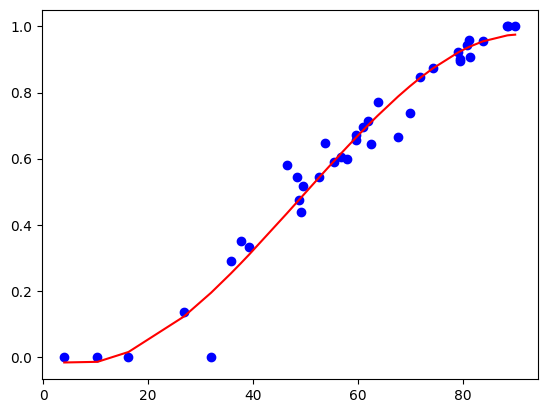

In [10]:
starts_poly_features, starts_model = show_poly_fit(X, y, bias=False, weights=weights, degrees=3)

It ultimately made little difference, but it doesn't hurt.

Another piece of the puzzle is calculating the average minutes given they started or did not start.

In [11]:
# Take two different means of minutes played
pmd['Mins_On'] = pmd['On'] * pmd['Mins']
agg = pmd.groupby('e_code').sum()
agg = agg.loc[agg.On > 0]
agg['Mins'] = agg.apply(lambda x: x['Mins'] / x['Plyd'], axis=1)
agg['Mins_On'] = agg.apply(lambda x: x['Mins_On'] / x['On'], axis=1)

agg.sort_values('Mins', ascending=False)[['Mins', 'Mins_On']].head(5)

,Mins,Mins_On
e_code,,
169187,83.811594,20.000000
199796,81.390625,24.833333
223340,81.105263,28.333333
184029,80.863014,24.500000
167199,79.526316,24.333333


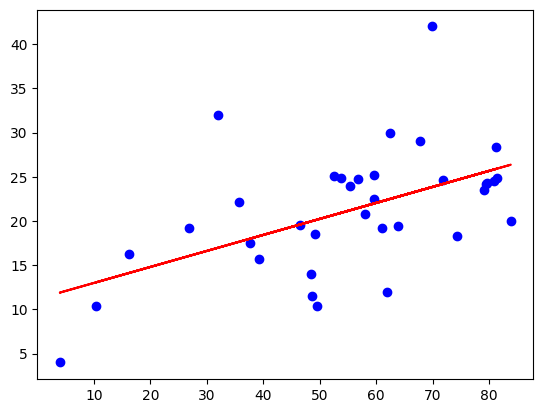

In [12]:
X = agg[['Mins']].values
y = agg[['Mins_On']].values

mins_on_model = show_linear_fit(X, y)

It is a little noisy, but there is correlation. I.e. Low p-value, moderate R-squared score.

Next, we need to find the probaility a player will finish given that they started.

In [13]:
pmd['Full'] = (pmd['Starts'] == 1) & (pmd['Off'] == 0)
agg = pmd.loc[pmd.Starts == 1].groupby('e_code').mean()

agg.sort_values('Mins', ascending=False).head(5)

,Mins,Starts,Plyd,On,Off,Available,Mins_On,Full
e_code,,,,,,,,
153256,90.000000,1.0,1.0,0.0,0.000000,0.888889,0.0,1.000000
116535,90.000000,1.0,1.0,0.0,0.000000,0.849315,0.0,1.000000
226597,88.684932,1.0,1.0,0.0,0.068493,1.000000,0.0,0.931507
98980,88.486111,1.0,1.0,0.0,0.027778,0.347222,0.0,0.972222
101184,88.000000,1.0,1.0,0.0,0.090909,1.000000,0.0,0.909091


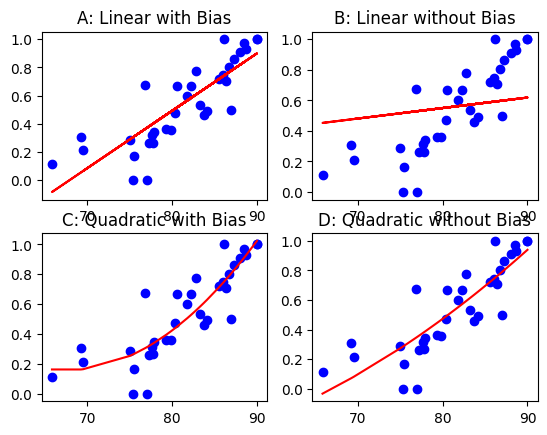

In [14]:
X = agg[['Mins']].values
y = agg['Full'].values

# Plot four plots
fig, axs = plt.subplots(2, 2)
show_linear_fit(X, y, ax=axs[0][0])
show_linear_fit(X, y, bias=False, ax=axs[0][1])
show_poly_fit(X, y, ax=axs[1][0])
full_poly_features, full_model = show_poly_fit(X, y, bias=False, ax=axs[1][1])

# Add titles
titles = {
    'A: Linear with Bias':(0, 0), 
    'B: Linear without Bias':(0, 1), 
    'C: Quadratic with Bias':(1, 0), 
    'D: Quadratic without Bias':(1, 1)
}
for title, pos in titles.items():
    axs[pos[0], pos[1]].set_title(title)

plt.show()

A: The linear model fits the data well given bias. However, like before, for Mins < 65, it implies negative probability. Unfortunately, there is no data for Mins < 65, and if we remove the bias, the fit is very poor.

B: As you can see, the linear model is a poor fit. There needs to be an asymptotic curve.

C: The parametric curve with bias does taper but doesn't tend to zero as required.

D: Again, the model fails because the curve dips below 0 and is objectively a bad model.

Since none of the linear/polynomial models are suitable, I am going to predict the log of y.

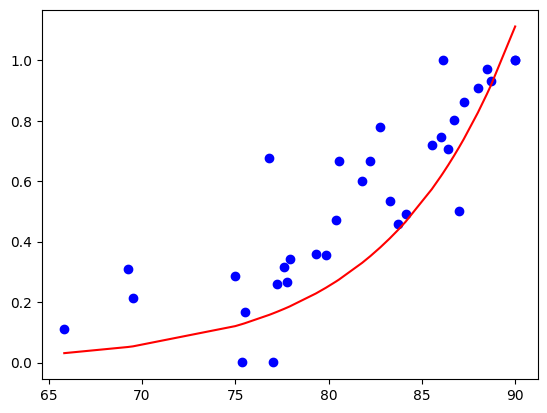

In [15]:
from sklearn.compose import TransformedTargetRegressor

def show_log_linear_fit(X, y):
    # Set pandas dfs to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Ensure there are no zero or negative values in y
    y += 0.0001
    assert (y > 0).all()

    # fit the transformed features to the TransformedTargetRegressor
    regr_trans = TransformedTargetRegressor(regressor=LinearRegression(),
                                            func=np.log,
                                            inverse_func=np.exp)

    regr_trans.fit(X, y)  # pass the sample

    #Predict y-values
    y_pred = regr_trans.predict(X)

    #Put data together and sort for plotting
    plot_data = np.hstack([X.flatten().reshape(-1, 1), y_pred.reshape(-1, 1)])
    plot_data = plot_data[np.argsort(plot_data[:, 0])]

    #Plot data
    plt.scatter(X, y, color='blue')
    plt.plot(plot_data[:, 0], plot_data[:, 1], color='red')
    plt.show()

    return regr_trans

_ = show_log_linear_fit(X, y)


In this example, most of the points are above the line, indicating a poor fit. I will settle for D in the last code block and clip at the boundary.

Lastly, my FPL model requires a standard deviation for the number of minutes played when a player is substituted. Lets fit a model which takes mean minutes as a feature and the corresponding standard deviation.

In [16]:
def agg_mean_std(q):
    agg = pmd.loc[q].groupby('e_code')['Mins'].agg(['mean', 'std', 'count'])
    return agg.dropna()

q = (pmd.On == 1) & (pmd.Off == 0)
agg = agg_mean_std(q)

agg.sort_values('mean', ascending=False).head(10)

,mean,std,count
e_code,,,
106468,50.000000,24.508502,4
85955,30.000000,10.700467,5
223340,28.333333,7.371115,3
447203,25.200000,11.516172,10
194634,25.100000,11.169900,10
215711,25.058824,9.276790,17
199796,24.833333,14.427982,6
200600,24.739130,15.457324,23
444145,24.600000,15.952708,10


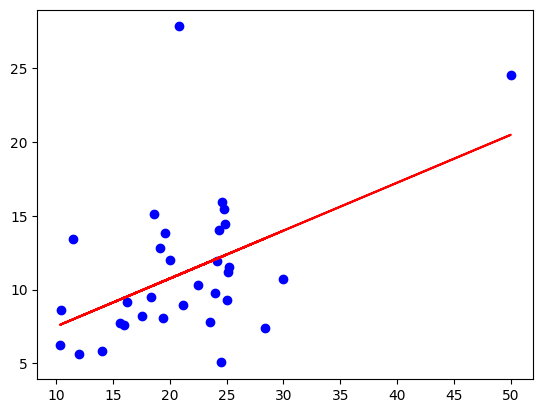

In [17]:
def split_agg(agg):
    return agg[['mean']].values, agg['std'].values, (agg['count'] - 1).values
X, y, weights = split_agg(agg)

on_std_model = show_linear_fit(X, y, weights=weights)

Notice firstly the two outliers which influence our fit. Lets remove them. Let's lets also find the p-value and R-squared score. The noisy nature of the data makes it difficult to verify visually.

With outliers:
p-value: 1.9265359579488056e-17	R-squared 0.132
Without outliers:
p-value: 2.2933989699556633e-18	R-squared 0.008


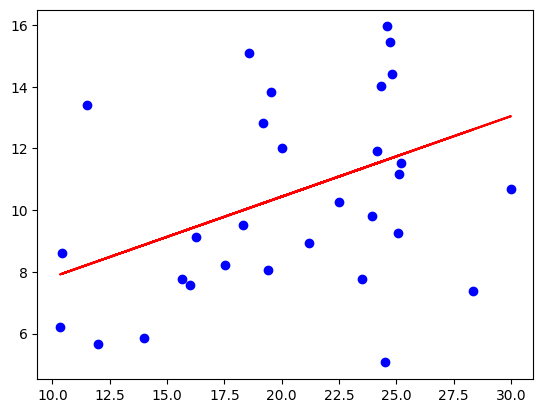

In [18]:
# Use statsmodels for their metrics
import statsmodels.api as sm
def show_WLS_metrics(X, y, weights):
    mod = sm.WLS(y, X, weights, hasconst=True)
    summary = mod.fit().summary2()

    print(
        f"p-value: {summary.tables[1]['P>|t|'][0]}",
        f"R-squared {summary.tables[0][1][6]}",
        sep="\t"
    )
# Print metrics for untruncated case
print("With outliers:")
show_WLS_metrics(X, y, weights=weights)

# Remove outliers
trunc_agg = agg.loc[(agg['mean'] < 40) & (agg['std'] < 20)]
trunc_X, trunc_y, trunc_weights = split_agg(trunc_agg)

# Fit again
print("Without outliers:")
show_WLS_metrics(trunc_X, trunc_y, weights=trunc_weights)
_ = show_linear_fit(trunc_X, trunc_y, weights=trunc_weights)

The p-value certainly indicates statistical significance, but the near-zero R-squared score (without outliers) show that the model performs equally to a naive mean model. Since we are indifferent for this set of data, and have a positive R-squared score with the full dataset, we should still use it.

We also need to do this for when a player starts and is subbed off.

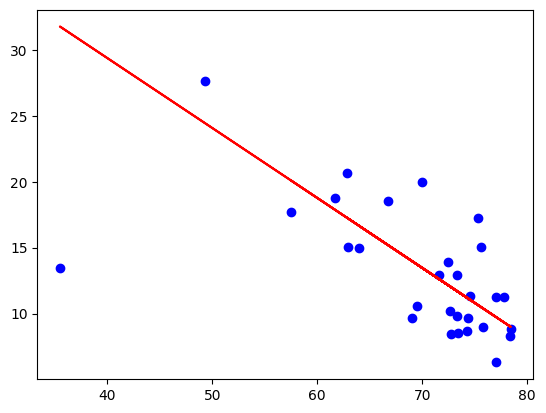

In [19]:
# Get arrays
q = (pmd.Starts == 1) & (pmd.Off == 1)
agg = agg_mean_std(q)
X, y, weights = split_agg(agg)

off_std_model = show_linear_fit(X, y, weights=weights)

Here is a clear negative correlation with no need for further analyis.

How should we combine these models?

In [20]:
clip_mins = lambda mins: np.clip(mins, 0, 90)
clip_prob = lambda prob: np.clip(prob, 0, 1)
wrap_elems = lambda arr: np.array([np.array([i]) for i in arr])

def deduce_breakdown(xMins):
    xMins = wrap_elems(xMins)

    # Probability they play
    xMins_poly = plyd_poly_features.transform(xMins)
    plyd = clip_prob(plyd_model.predict(xMins_poly))
    
    # Expected minutes if they play
    plyd_xMins = wrap_elems(clip_mins(xMins.flatten() / plyd))
    
    # Expected minutes if they're subbed on
    on_xMins = clip_mins(mins_on_model.predict(plyd_xMins))

    # Expected standard deviation in minutes if subbed on and finish
    on_stdMins = on_std_model.predict(on_xMins)

    # Probabililty they start given they play
    plyd_xMins_poly = starts_poly_features.transform(plyd_xMins)
    starts = clip_prob(starts_model.predict(plyd_xMins_poly))
    
    # Expected minutes if they start
    starts_xMins = clip_mins((plyd_xMins.flatten() - (1-starts) \
                                     * on_xMins.flatten()) / starts)
    
    # Probability they play the full match if they start
    starts_xMins_poly = full_poly_features.transform(wrap_elems(starts_xMins))
    full = clip_prob(full_model.predict(starts_xMins_poly))

    # Expected minutes if they did not finish
    off_xMins = clip_mins((starts_xMins - (full-0.01)*90) / (1 - (full-0.01)))

    # Expected standard deviation in minutes if subbed on and finish
    off_stdMins = off_std_model.predict(wrap_elems(off_xMins))

    # Set probabilities to non-conditional
    starts *= plyd
    full *= starts

    return {
        'plyd':plyd,
        'starts':starts,
        'on':plyd-starts,
        'off':starts-full,
        'full':full,
        'xMins':xMins.flatten(),
        'plyd_xMins':plyd_xMins.flatten(),
        'starts_xMins':starts_xMins,
        'on_xMins':on_xMins.flatten(),
        'off_xMins':off_xMins,
        'on_stdMins':on_stdMins,
        'off_stdMins':off_stdMins
    }

col_dict = deduce_breakdown([45, 74])
col_dict

{'plyd': array([0.714865 , 0.9309271]),
 'starts': array([0.51270945, 0.86065111]),
 'on': array([0.20215555, 0.07027598]),
 'off': array([0.29482874, 0.3068643 ]),
 'full': array([0.2178807 , 0.55378681]),
 'xMins': array([45, 74]),
 'plyd_xMins': array([62.94894879, 79.49064999]),
 'starts_xMins': array([78.86360731, 83.89239828]),
 'on_xMins': array([22.58599196, 25.58362045]),
 'off_xMins': array([70.96475195, 73.33755773]),
 'on_stdMins': array([11.58664118, 12.55897614]),
 'off_stdMins': array([12.94920771, 11.68903046])}

In [21]:
def print_col_dict(plyd, starts, on, off, full, xMins, plyd_xMins, starts_xMins, on_xMins, off_xMins, on_stdMins, off_stdMins, idx=0):
    print(
        f"They play {plyd[idx]:.0%} of the time.",
        f"They start {starts[idx]:.0%} of the time.",
        f"They are subbed on {on[idx]:.0%} of the time.",
        f"They start and are subbed off {off[idx]:.0%} of the time.",
        f"They play the full 90 minutes {full[idx]:.0%} of the time.",
        f"They play an average of {xMins[idx]:.0f} minutes.",
        f"They play an average of {plyd_xMins[idx]:.0f} minutes given they play.",
        f"They play an average of {starts_xMins[idx]:.0f} minutes given they start.",
        f"They play an average of {on_xMins[idx]:.0f} minutes given they're subbed on.",
        f"They play an average of {off_xMins[idx]:.0f} minutes given they start and do not finish.",
        f"They have a standard deviation of {on_stdMins[idx]:.0f} minutes given they are substituted on and finish.",
        f"They have a standard deviation of {off_stdMins[idx]:.0f} minutes given they start and get substituted off.",
        sep='\n'
    )

# Print 45 xMins case
print_col_dict(**col_dict, idx=0)

They play 71% of the time.
They start 51% of the time.
They are subbed on 20% of the time.
They start and are subbed off 29% of the time.
They play the full 90 minutes 22% of the time.
They play an average of 45 minutes.
They play an average of 63 minutes given they play.
They play an average of 79 minutes given they start.
They play an average of 23 minutes given they're subbed on.
They play an average of 71 minutes given they start and do not finish.
They have a standard deviation of 12 minutes given they are substituted on and finish.
They have a standard deviation of 13 minutes given they start and get substituted off.


I am now ready to apply this to the external xMins dataset.

In [22]:
# External dataset with xMins
df = pd.read_csv('../views/fplreview_projections.csv')

# Unpivot the table to have GWs in seperate rows rather than columns
melted = pd.melt(df, id_vars=['Pos', 'ID', 'Name', 'BV', 'SV', 'Team', 'Elite%'], 
                 value_vars=['1_xMins', '1_Pts', '2_xMins', '2_Pts', '3_xMins', '3_Pts', '4_xMins', '4_Pts', 
                             '5_xMins', '5_Pts', '6_xMins', '6_Pts', '7_xMins', '7_Pts', '8_xMins', '8_Pts', 
                             '9_xMins', '9_Pts', '10_xMins', '10_Pts', '11_xMins', '11_Pts', '12_xMins', '12_Pts'], 
                 var_name='Round', value_name='Value')

# Splitting the 'Round' column to get 'Round', 'xMins', and 'Pts' columns
melted['GW'] = melted['Round'].str.split('_').str[0]
melted['Type'] = melted['Round'].str.split('_').str[1]
unpivot_df = melted.pivot_table(index=['Pos', 'ID', 'Name', 'BV', 'SV', 'Team', 'Elite%', 'GW'], 
                                columns='Type', 
                                values='Value').reset_index()

unpivot_df.sample(15)

Type,Pos,ID,Name,BV,SV,Team,Elite%,GW,Pts,xMins
2127,D,536,Johnson,4.5,4.5,West Ham,0.00,12,0.61,14.0
5208,M,137,Kozłowski,4.5,4.5,Brighton,0.00,1,0.00,0.0
266,D,75,Mepham,4.5,4.5,Bournemouth,0.00,11,0.59,60.0
3916,G,289,Adrián,4.0,4.0,Liverpool,0.00,2,0.00,0.0
1989,D,508,Reguilón,4.5,4.5,Spurs,0.00,7,0.34,9.0
1384,D,374,B.Williams,4.0,4.0,Man Utd,0.00,2,0.00,0.0
5058,M,111,Onyeka,5.0,5.0,Brentford,0.00,4,0.92,19.0
3490,F,10062,Rasmus Højlund,99.9,99.9,Man Utd,0.00,8,2.53,38.0
3920,G,289,Adrián,4.0,4.0,Liverpool,0.00,6,0.00,0.0
773,D,206,James,5.5,5.5,Chelsea,0.15,3,5.19,73.0


In [23]:
# Apply models
cols_dict = deduce_breakdown(unpivot_df['xMins'])
unpivot_df[list(cols_dict.keys())] = pd.DataFrame(cols_dict)

pd.set_option('display.max_columns', 21)
unpivot_df.sample(15)

/tmp/ipykernel_3344/528452850.py:26: RuntimeWarning: divide by zero encountered in divide
  starts_xMins = clip_mins((plyd_xMins.flatten() - (1-starts) \


Type,Pos,ID,Name,BV,SV,Team,Elite%,GW,Pts,xMins,plyd,starts,on,off,full,plyd_xMins,starts_xMins,on_xMins,off_xMins,on_stdMins,off_stdMins
4069,G,409,Dubravka,4.0,4.0,Newcastle,0.01,10,0.21,5.0,0.103309,0.048410,0.054899,0.024185,0.024225,48.398419,80.660809,19.949197,71.673141,10.731349,12.572988
17,D,5,Gabriel,5.0,5.0,Arsenal,0.24,3,3.70,82.0,0.956904,0.922545,0.034360,0.153601,0.768944,85.692982,87.889864,26.707585,78.044362,12.923554,9.189286
5769,M,256,Iwobi,5.5,5.5,Everton,0.01,7,2.92,67.0,0.896269,0.787141,0.109128,0.358188,0.428953,74.754363,81.690308,24.725327,72.131603,12.280573,12.329503
1354,D,368,Stones,5.5,5.5,Man City,0.28,8,2.07,63.0,0.871466,0.740300,0.131165,0.365466,0.374834,72.292016,80.798867,24.279109,71.731938,12.135834,12.541761
5824,M,269,I.Cavaleiro,5.0,5.0,Fulham,0.00,2,0.34,5.0,0.103309,0.048410,0.054899,0.024185,0.024225,48.398419,80.660809,19.949197,71.673141,10.731349,12.572988
1895,D,480,Egan,4.5,4.5,Sheffield Utd,0.00,9,1.53,74.0,0.930927,0.860651,0.070276,0.306864,0.553787,79.490650,83.892398,25.583620,73.337558,12.558976,11.689030
6352,M,372,Antony,7.0,7.0,Man Utd,0.02,2,2.85,60.0,0.850477,0.703689,0.146788,0.363390,0.340299,70.548604,80.266229,23.963175,71.509030,12.033355,12.660146
5631,M,231,Lerma,5.0,5.0,Crystal Palace,0.00,12,1.97,63.0,0.871466,0.740300,0.131165,0.365466,0.374834,72.292016,80.798867,24.279109,71.731938,12.135834,12.541761
4110,G,448,Hennessey,4.0,4.0,Nott'm Forest,0.01,4,1.59,47.0,0.735900,0.538355,0.197545,0.307568,0.230787,63.867348,78.954131,22.752421,70.998326,11.640625,12.931377
4629,M,40,Dendoncker,5.0,5.0,Aston Villa,0.00,7,0.42,10.0,0.199634,0.099536,0.100098,0.052119,0.047417,50.091708,80.096027,20.256048,71.439917,10.830882,12.696851


Nice! Unfortunately, it still doesn't work too well for double gameweeks as we do not get xMins seperated for gameweeks with more than one game (a data issue). However, it is good enough for the purposes of my Fantasy Premier League model.